Import necessary libraries


In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


The data set used, originated from a google sheet where Null data can be represented as #N/A or similar. These are changed to the NaN type upon read.

In [12]:
# Loading the labeled dataset
df = pd.read_csv('Labeled.csv', na_values=['#N/A', 'N/A', '#N/A N/A'])

In [13]:
# Display column names and data types
print(df.info())

# Show a summary of the data
print(df.describe())

# Check for missing values
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Y          1111 non-null   int64  
 1   Date       1111 non-null   object 
 2   XAU BGNL   1111 non-null   float64
 3   ECSURPUS   1111 non-null   float64
 4   BDIY       1111 non-null   float64
 5   CRY        1111 non-null   float64
 6   DXY        1111 non-null   float64
 7   JPY        1111 non-null   float64
 8   GBP        1111 non-null   float64
 9   Cl1        1111 non-null   float64
 10  VIX        1111 non-null   float64
 11  USGG30YR   1111 non-null   float64
 12  GT10       1111 non-null   float64
 13  USGG2YR    1111 non-null   float64
 14  USGG3M     1111 non-null   float64
 15  US0001M    1111 non-null   float64
 16  GTDEM30Y   1111 non-null   float64
 17  GTDEM10Y   1111 non-null   float64
 18  GTDEM2Y    1111 non-null   float64
 19  EONIA      1111 non-null   float64
 20  GTITL30Y

It seems that all enteries require no further cleaning. It's time to make sure the data is standardizable

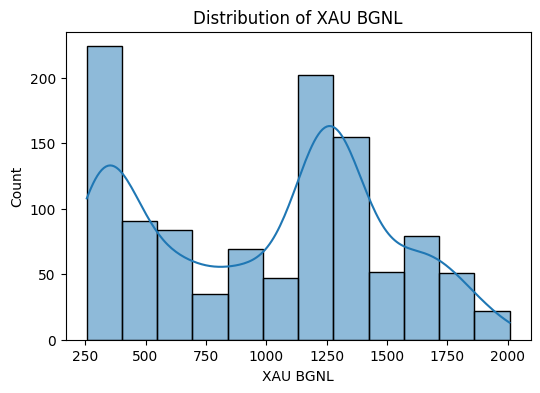

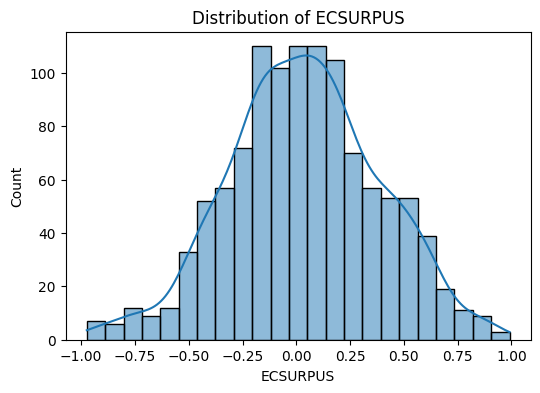

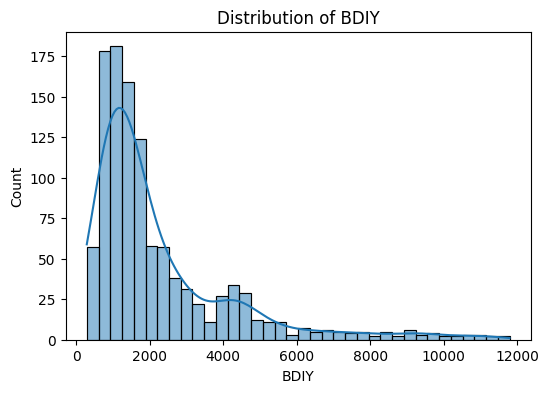

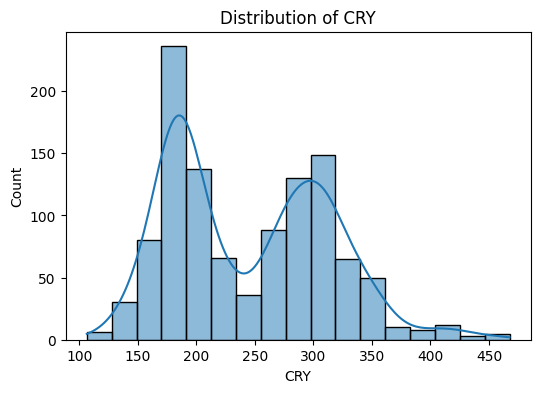

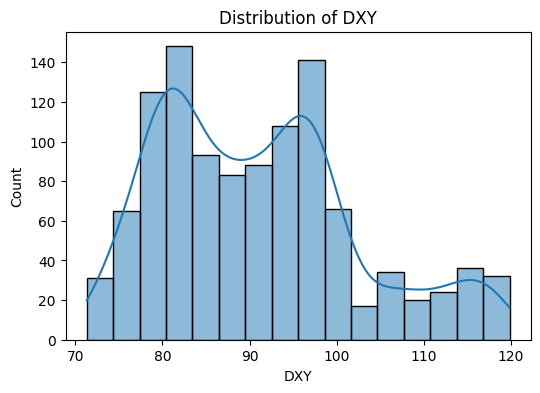

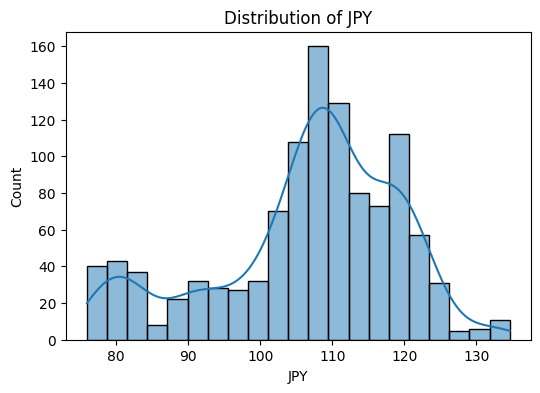

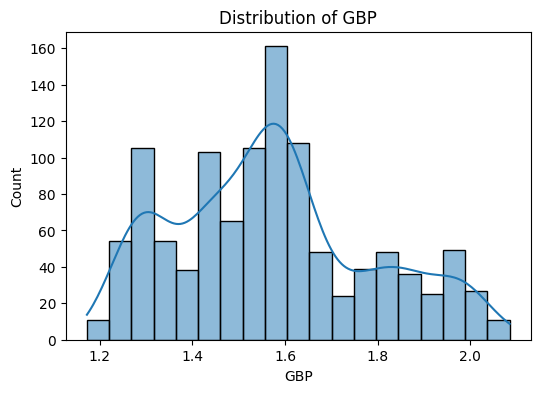

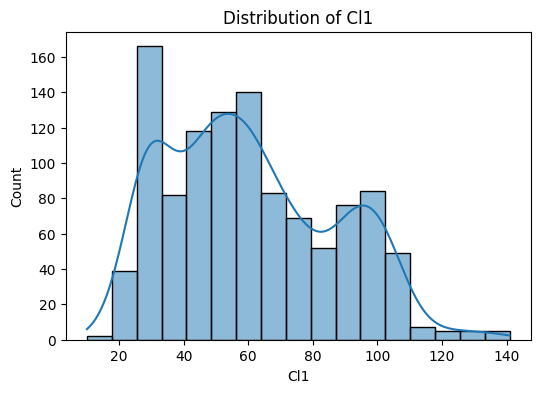

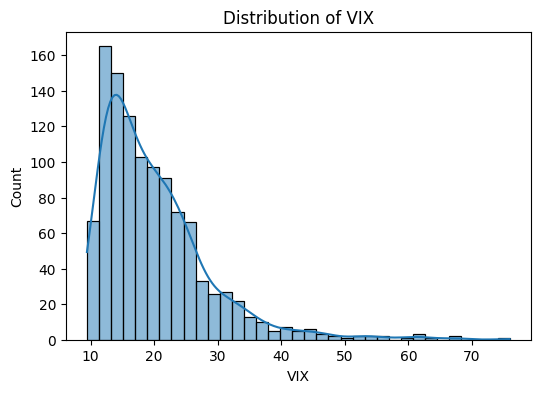

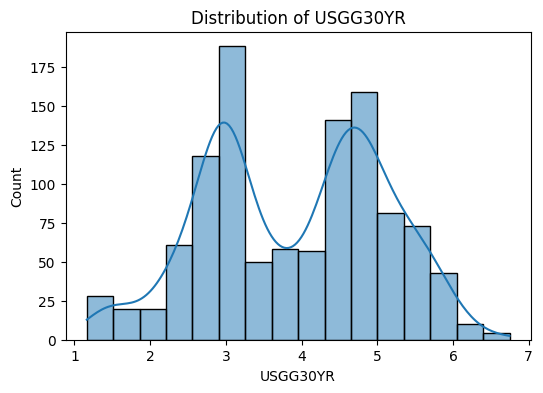

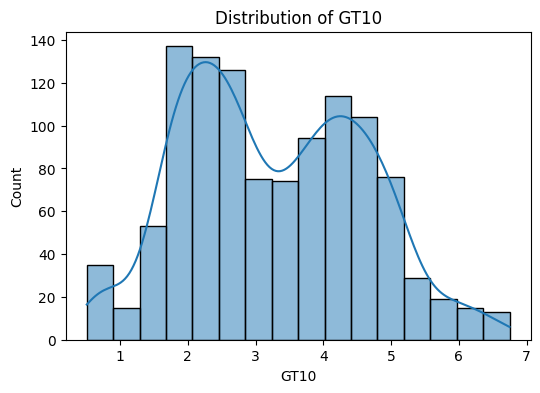

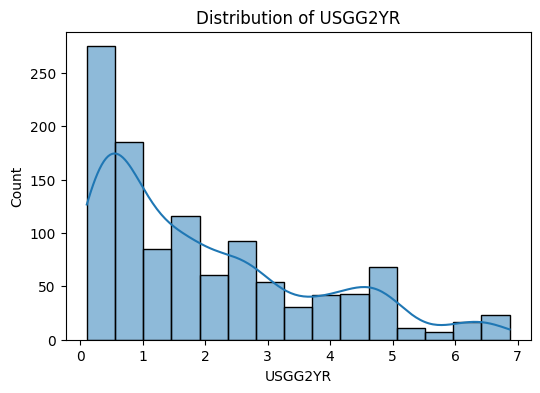

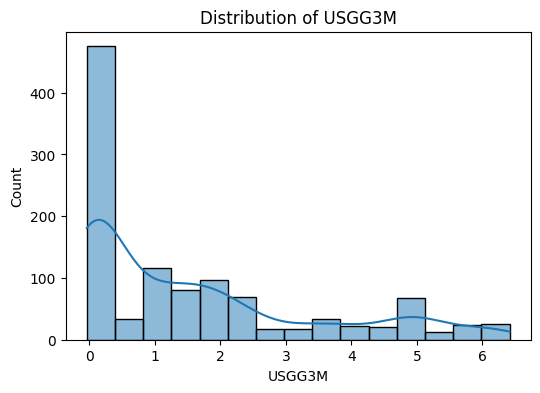

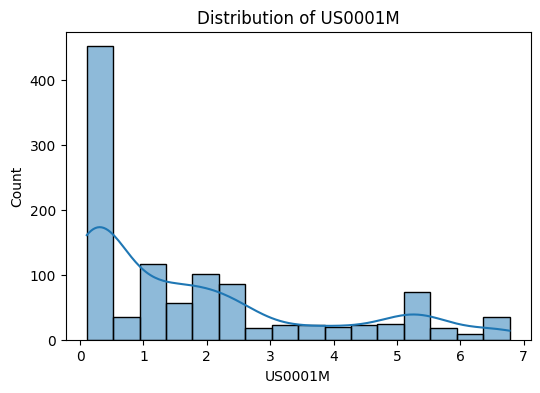

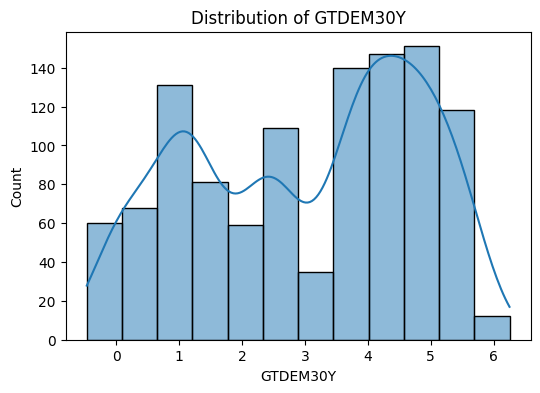

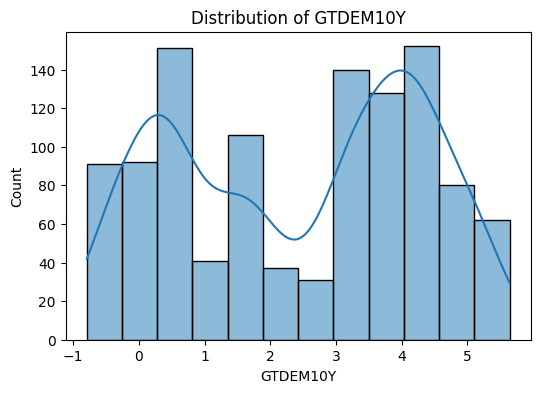

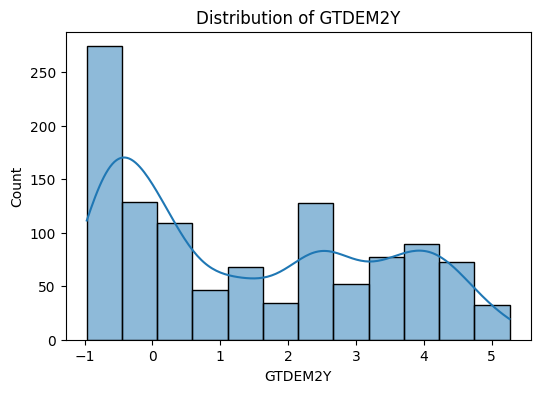

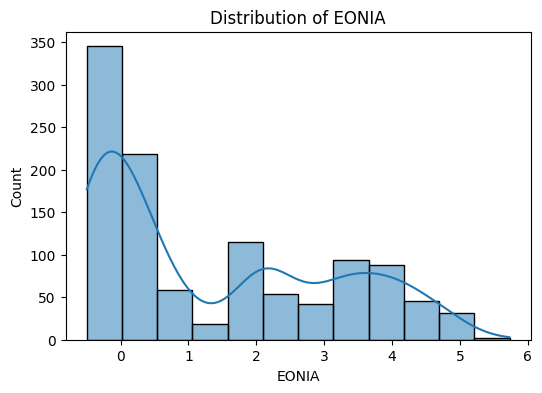

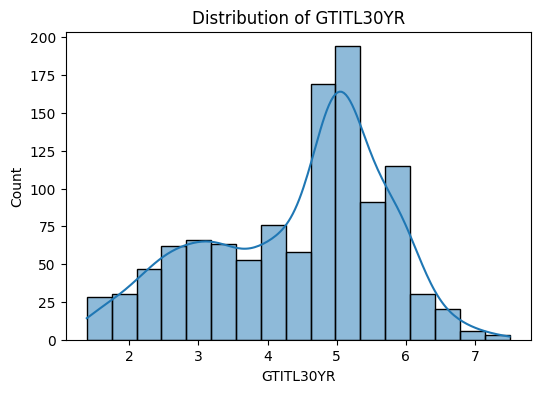

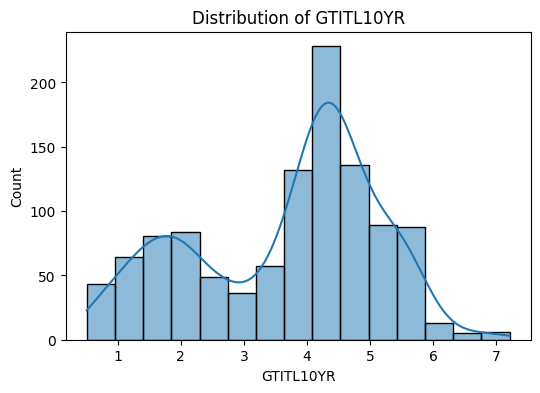

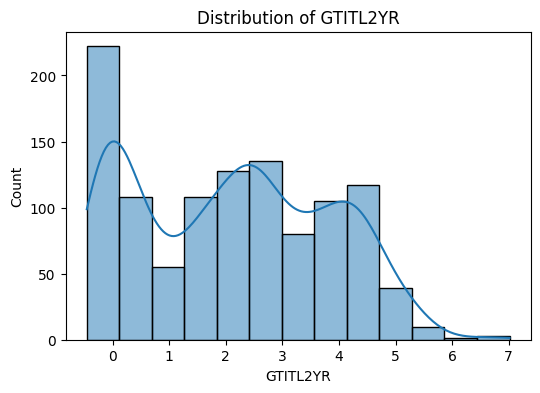

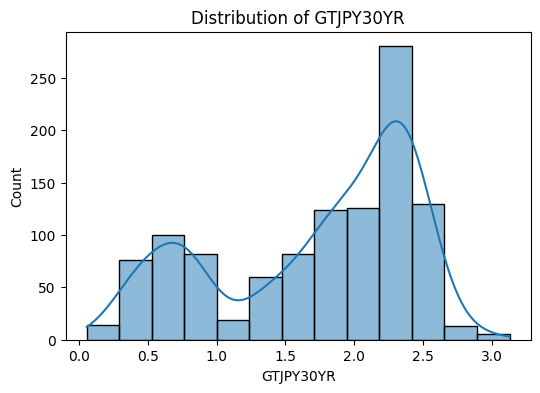

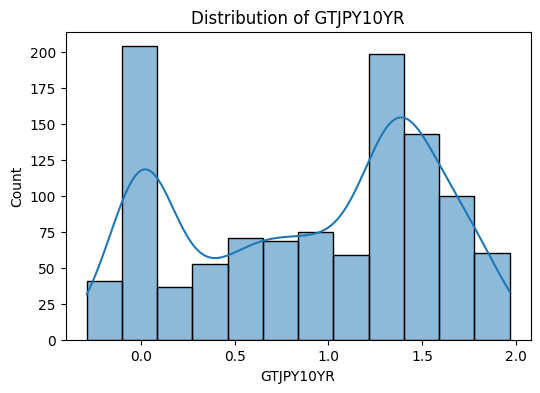

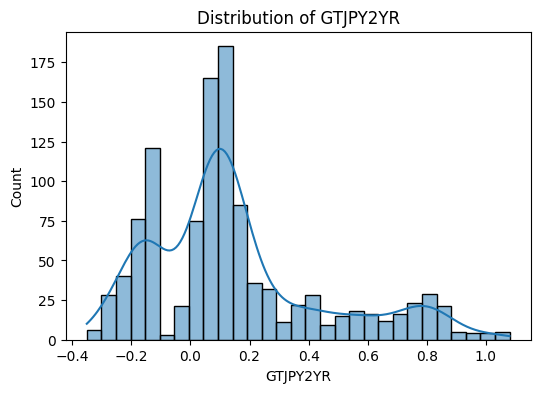

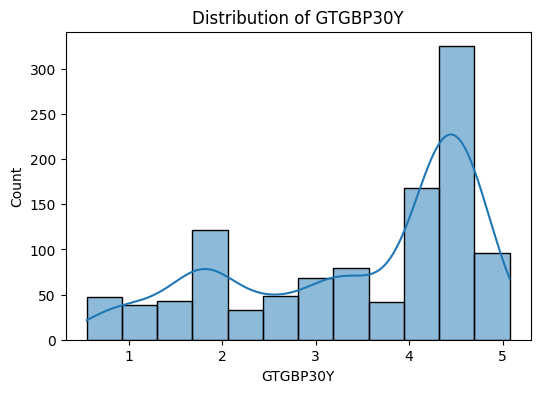

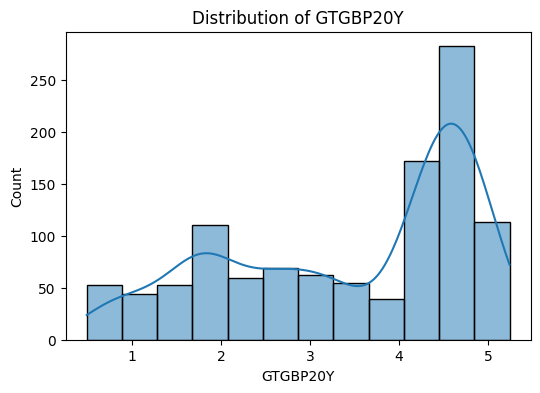

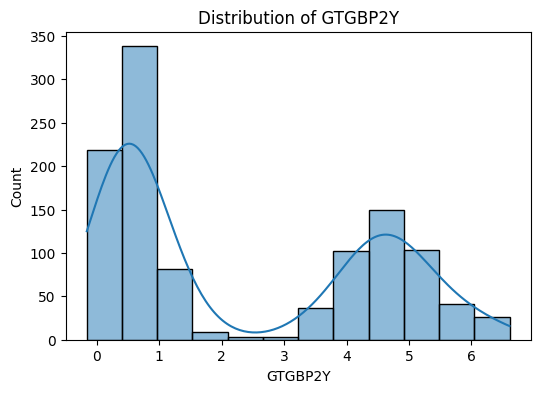

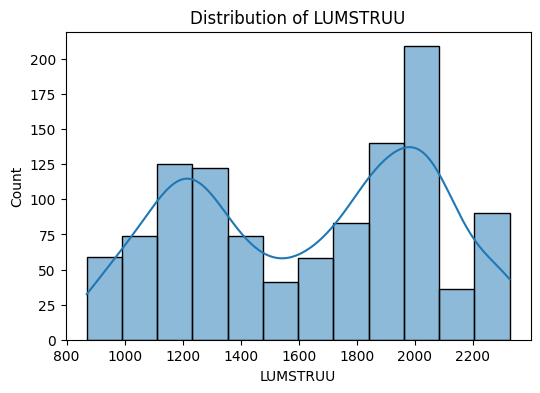

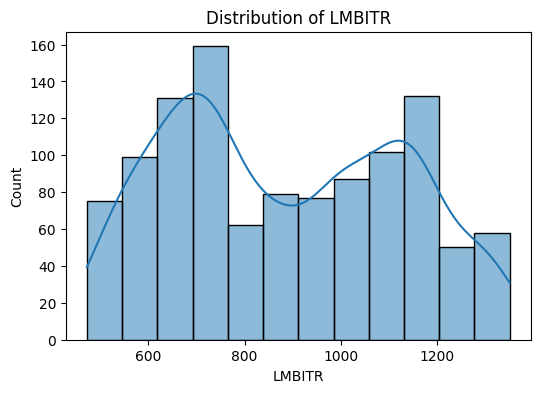

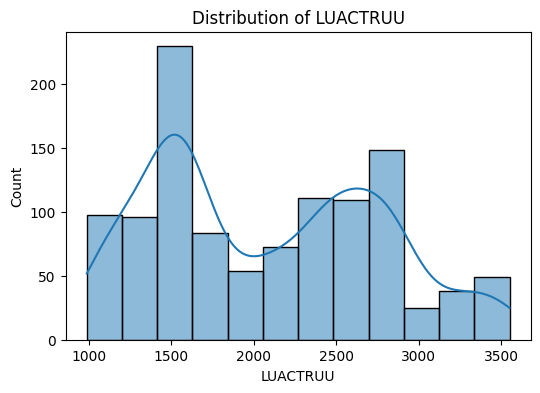

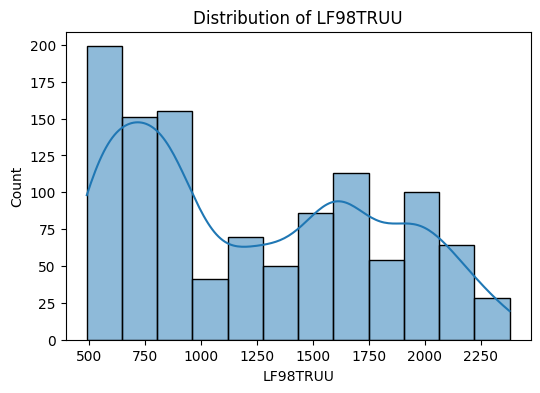

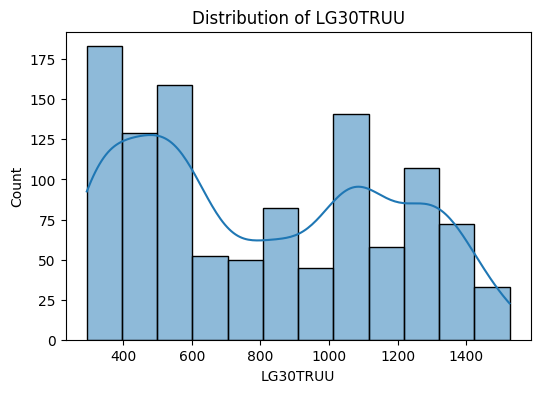

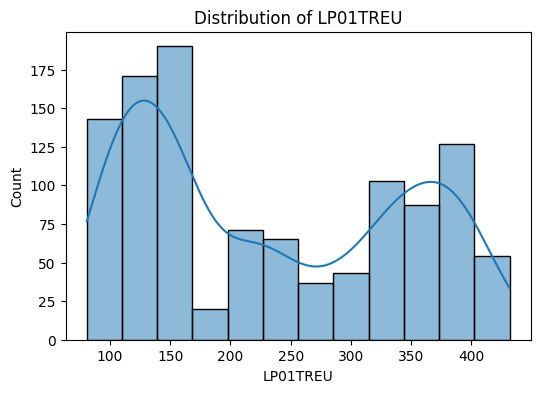

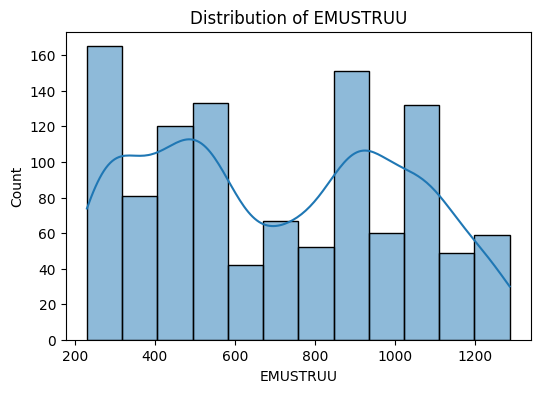

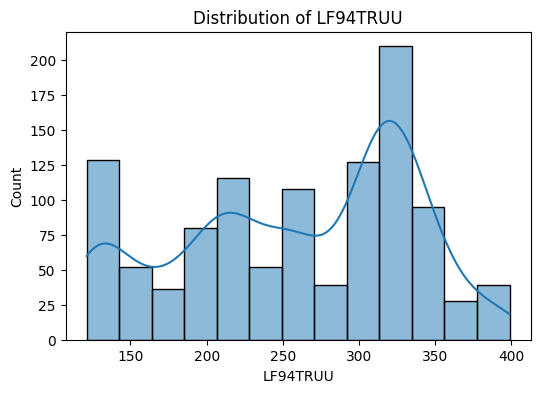

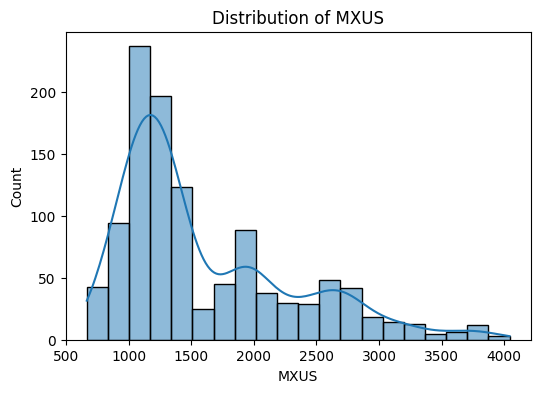

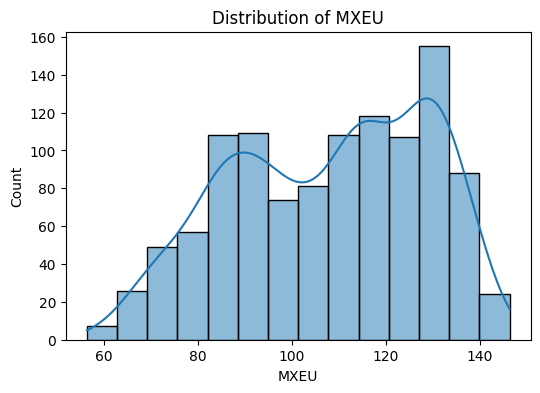

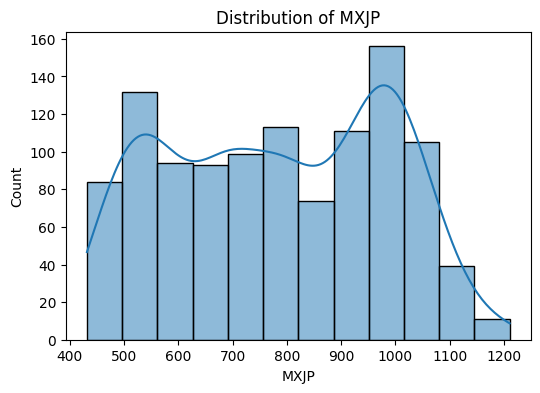

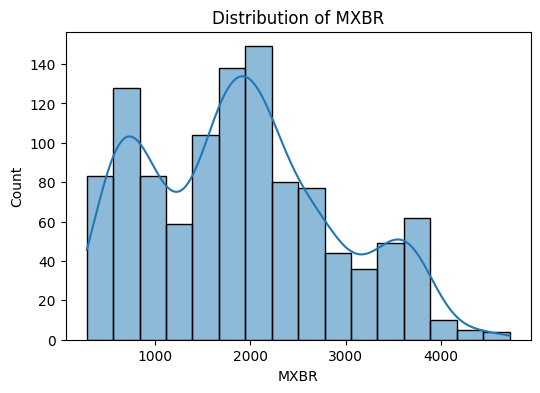

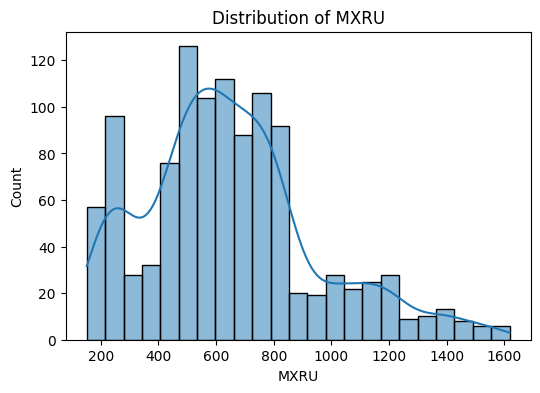

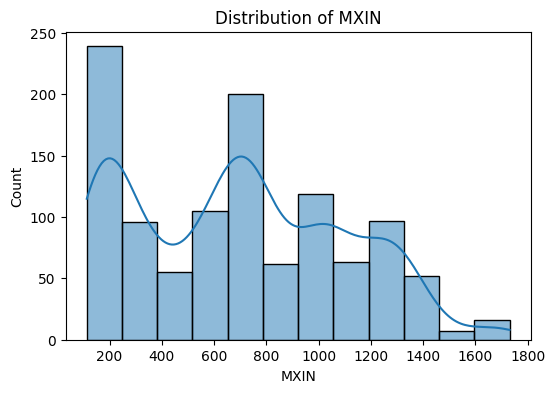

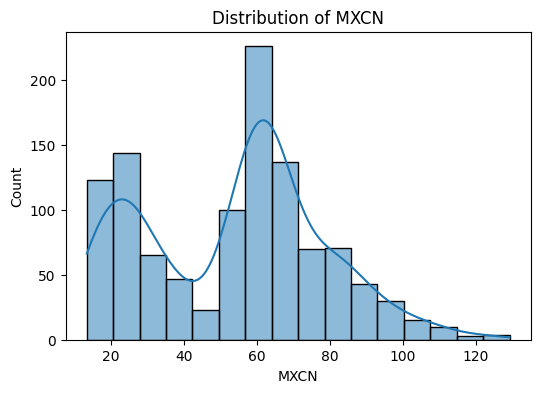

In [14]:
# Plot histogram and density plot for each feature
for column in df.iloc[:, 2:].columns:  # There are the numeric features
    plt.figure(figsize=(6, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

Most of the features blatantly to be non-gaussian distributions - therfore we will skip gaussian tests and conclude that this data must be normalized instead of standardized

In [15]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.iloc[:, 2:])  # Excluding non-numeric column Date 
df = pd.DataFrame(df_scaled, columns=df.columns[2:])

With our data cleaned and normalized, we will change the date column into a proper datetime format and features for year and month.

This is in hopes that cycles of months or years could predict a crash.

In [16]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Two extra features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month